## OBJECTIVE : 
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

# Importing Libraries & getting Data

In [1]:
import numpy as np 
import pandas as pd 
import sqlite3 
import matplotlib.pyplot as plt 
import seaborn as sns 

import re 
import math 
import os 
import string 
from tqdm import tqdm 

import warnings 
warnings.filterwarnings('ignore')

# Metrics libraries
from sklearn.metrics import accuracy_score ,confusion_matrix, roc_curve, auc ,roc_auc_score

# NLP libraries 
import nltk 
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer 
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from gensim.models import Word2Vec 
from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.python.client import device_lib

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1625018951810955982
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1753127323
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13983469077792818546
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [4]:
connection = sqlite3.connect('G:/My Drive/datasets/amazon food review/dataset/database.sqlite')

# ignoring datapoints where score = 3 (neutral review)

filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score != 3
LIMIT 100000
""" ,connection)


In [5]:
# label encoding score into positive (x>3) and negative (x<3)

def partition(x):
    if x< 3:
        return 0 
    else: 
        return 1 

score_with_neutral = filtered_data['Score']
score_wo_neutral = score_with_neutral.map(partition)

filtered_data['Score'] = score_wo_neutral 

In [6]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      100000 non-null  int64 
 1   ProductId               100000 non-null  object
 2   UserId                  100000 non-null  object
 3   ProfileName             100000 non-null  object
 4   HelpfulnessNumerator    100000 non-null  int64 
 5   HelpfulnessDenominator  100000 non-null  int64 
 6   Score                   100000 non-null  int64 
 7   Time                    100000 non-null  int64 
 8   Summary                 100000 non-null  object
 9   Text                    100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [8]:
filtered_data.shape

(100000, 10)

In [9]:
display = pd.read_sql_query("""
SELECT UserId, ProductId ,ProfileName ,Time, Score ,Text ,COUNT(*)
FROM Reviews 
GROUP BY UserId 
HAVING COUNT(*) > 1
""" ,connection) 

display.head()

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [10]:
display.shape 

(80668, 7)

In [11]:
display['COUNT(*)'].sum()

393063

# EDA

## Data Cleaning (Removing Duplicates)

In [12]:
display = pd.read_sql_query("""
SELECT * 
FROM Reviews 
WHERE Score != 3 AND UserId='#oc-R11D9D7SHXIJB9'
ORDER BY ProductId
""" ,connection)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
1,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
2,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


#### NOTE : 
- It can be seen that same user has multiple reviews with same values for all the parameters.

- So, in order to get unbiased results ,we need to remove the rows having same parameters.

- Steps to do so : 
    - first sort the data according to ProductId in ascending order.
    - Then just keep the first similar product review and delete the others.

In [13]:
sorted_data = filtered_data.sort_values('ProductId' ,axis=0 ,ascending=True ,inplace=False ,kind='quicksort' ,na_position='last')

In [14]:
clean_data = sorted_data.drop_duplicates(
    subset={"UserId", "ProfileName", "Time", "Text"} ,keep='first' ,inplace=False)

clean_data.shape

(87775, 10)

# Data Preprocessing

#### Steps : 

1. Begin by removing the HTML tags

2. Remove any punctuations or limited set of special characters like , or . etc

3. Check if the word is made up of english letters and is not alpha-numeric.

4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5. Convert the words to lowercase

6. Remove Stopwords

7. Stemming the word 

In [15]:
# sample reviews 

review_1 = clean_data['Text'].values[0]
print(review_1)
print('---------------------------------------')

review_2 = clean_data['Text'].values[1]
print(review_2)
print('---------------------------------------')

review_3 = clean_data['Text'].values[2]
print(review_3)



My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
---------------------------------------
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
---------------------------------------
I had an infestation of fruitflies, they were literally everywhere flying around me in my  kitchen, so I bought this product hoping to at least get rid of a few. But after 2 weeks, only 1 fly had stuck... I was going around with a notepad and squishing the buggers myself with a success rate of 2-3 a day so clearly this product was useless! I even dabbed to red wine and banana to the top of the column after 1 week because they were really attrac

### 1. Removing URLs

In [16]:
review_1 = re.sub('http\S+' ,"" ,review_1)
review_2 = re.sub('http\S+', "", review_2)
review_3 = re.sub('http\S+', "", review_3)

### 2. Removing HTML tags

In [17]:
from bs4 import BeautifulSoup 

soup = BeautifulSoup(review_1 ,'lxml')
review_1 = soup.get_text()

soup = BeautifulSoup(review_2 ,'lxml')
review_2 = soup.get_text()

soup = BeautifulSoup(review_3, 'lxml')
review_3 = soup.get_text()


### 3. Removing Apostrophes

In [18]:
def removing_apostrophes(text):
    # general
    text = re.sub("n\'t", " not", text)
    text = re.sub("\'re", " are", text)
    text = re.sub("\'s", " is", text)
    text = re.sub("\'d", " would", text)
    text = re.sub("\'ll", " will", text)
    text = re.sub("\'t", " not", text)
    text = re.sub("\'ve", " have", text)
    text = re.sub("\'m", " am", text)

    text = re.sub("won't", "will not", text)
    text = re.sub("can\'t", "can not", text)

    return text


In [19]:
# isn't gets converted to 'is not' in line 3
review_3 = removing_apostrophes(review_3)
print(review_3)

I had an infestation of fruitflies, they were literally everywhere flying around me in my  kitchen, so I bought this product hoping to at least get rid of a few. But after 2 weeks, only 1 fly had stuck... I was going around with a notepad and squishing the buggers myself with a success rate of 2-3 a day so clearly this product was useless! I even dabbed to red wine and banana to the top of the column after 1 week because they were really attracted to any red wine I had in a glass... but still it did nothing to get them stuck. And then I actually saw a second fly land on it once, and I watched as it flapped it is wings frantically and within 30 secs it had unstuck itself!!!! This product was a total waste of money!


### 4. Removing Numbers / Punctuations /Special Characters

In [20]:
# removing numbers
review_1 = re.sub('\S*\d\S*' ,"" ,review_1).strip()
print(review_1) 
print('-----------------------------------------')

# removing special characters 
review_3 = re.sub('[^A-Za-z0-9]+', ' ' ,review_3)
print(review_3)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
-----------------------------------------
I had an infestation of fruitflies they were literally everywhere flying around me in my kitchen so I bought this product hoping to at least get rid of a few But after 2 weeks only 1 fly had stuck I was going around with a notepad and squishing the buggers myself with a success rate of 2 3 a day so clearly this product was useless I even dabbed to red wine and banana to the top of the column after 1 week because they were really attracted to any red wine I had in a glass but still it did nothing to get them stuck And then I actually saw a second fly land on it once and I watched as it flapped it is wings frantically and within 30

### 5. Removing Stopwords

In [21]:
# removing the following words from the stop words list: 'no', 'nor', 'not'

stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
                 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',
                 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
                 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
                 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
                 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
                 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
                 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
                 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
                 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                 "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
                 "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
                 'won', "won't", 'wouldn', "wouldn't"])

### Combining all Steps

In [22]:
from tqdm import tqdm 
preprocessed_reviews = []

for text in tqdm(clean_data['Text'].values):
    text = re.sub('http\S+',"" ,text)
    text = BeautifulSoup(text, 'lxml').get_text()

    text = removing_apostrophes(text)

    text = re.sub('\S*\d\S*', "", text).strip()
    text = re.sub('[^A-Za-z0-9]+', ' ', text)

    text = ' '.join(i.lower() for i in text.split() if i.lower() not in stopwords)

    preprocessed_reviews.append(text.strip())


100%|██████████| 87775/87775 [00:26<00:00, 3303.52it/s]


## Splitting into train, test & validation sets

In [23]:
X = preprocessed_reviews 
y = np.array(clean_data['Score'])

In [24]:
from sklearn.model_selection import train_test_split

X_train ,X_test ,y_train ,y_test = train_test_split(X, y, test_size=0.3)

X_train, X_val ,y_train ,y_val = train_test_split(X_train ,y_train ,test_size=0.3)

# Models

In [25]:
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score


## 1. Bag of Words (BoW) - Random Forest

In [26]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)
X_val_bow = vectorizer.transform(X_val)

scaler = StandardScaler(with_mean=False) 
X_train_bow = scaler.fit_transform(X_train_bow)
X_test_bow = scaler.transform(X_test_bow)
X_val_bow = scaler.transform(X_val_bow)


### 1.1 Hyperparameter Tuning (GridSearchCV)

In [27]:
base_learners = [20,40,60,80,100,120]
depths = [1,5,10,50,100,500,1000]

parameter_grid = {'n_estimators': base_learners ,'max_depth':depths}

In [28]:
rf_model = RandomForestClassifier(max_features='sqrt')
model = HalvingGridSearchCV(rf_model ,parameter_grid ,scoring='roc_auc' ,cv=2 ,verbose=3)

model.fit(X_train_bow ,y_train) 
print('Optimal number of estimators --> ', model.best_estimator_.n_estimators)
print('Optimal max_depth --> ',model.best_estimator_.max_depth)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1592
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 42
n_resources: 1592
Fitting 2 folds for each of 42 candidates, totalling 84 fits
[CV 1/2] END max_depth=1, n_estimators=20;, score=(train=0.636, test=0.567) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=20;, score=(train=0.636, test=0.535) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=40;, score=(train=0.712, test=0.582) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=40;, score=(train=0.680, test=0.560) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=60;, score=(train=0.751, test=0.569) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=60;, score=(train=0.783, test=0.610) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=80;, score=(train=0.848, test=0.699) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=80;, score=(train=0.810, test=0.

In [29]:
X=[]
Y=[]
Z_train =[]
Z_cv =[]

for i in base_learners:
    for j in depths:
        classifier = RandomForestClassifier(max_features='sqrt',n_estimators=i,max_depth=j)
        classifier.fit(X_train_bow, y_train)
        
        # predicted values for train & validation data
        y_pred_rf_bow = classifier.predict_proba(X_train_bow)[:,1]
        y_pred_rf_bow_cv = classifier.predict_proba(X_val_bow)[:,1]
        
        # appending values to resp. lists 
        X.append(i)
        Y.append(j)
        Z_train.append(roc_auc_score(y_train, y_pred_rf_bow))
        Z_cv.append(roc_auc_score(y_val, y_pred_rf_bow_cv))
        
traindata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_train})
cvdata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_cv})


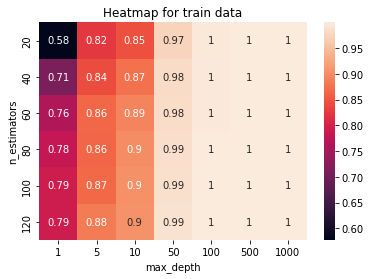

In [30]:
# Heatmap for train data
traindata_pivoted = traindata.pivot('n_estimators' ,'max_depth' ,'AUC')

sns.heatmap(traindata_pivoted,annot=True)
plt.title('Heatmap for train data')
plt.show()

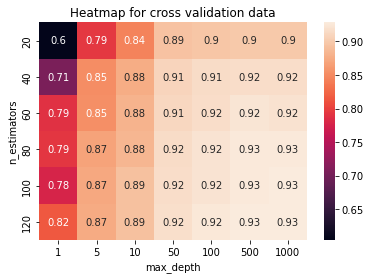

In [49]:
# Heatmap for cross validation data
cvdata_pivoted = cvdata.pivot('n_estimators' ,'max_depth' ,'AUC')

sns.heatmap(cvdata_pivoted,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

### 1.2 Model Building (RF - BoW - GridSearchCV)

In [32]:
rf_model_bow_gs = RandomForestClassifier(max_features='sqrt',n_estimators=model.best_estimator_.n_estimators,max_depth=model.best_estimator_.max_depth)
rf_model_bow_gs.fit(X_train_bow ,y_train)

# predicted values for train & test data
y_pred_rf_bow = rf_model_bow_gs.predict_proba(X_train_bow)[:,1] 
y_pred_rf_bow_test = rf_model_bow_gs.predict_proba(X_test_bow)[:,1]


### 1.3 Model Evaluation (RF - BoW - GridSearchCV)

In [33]:
print('Accuracy of RF-BoW-GridSearchCV model : ',rf_model_bow_gs.score(X_test_bow ,y_test))

Accuracy of RF-BoW-GridSearchCV model :  0.8704667147685414


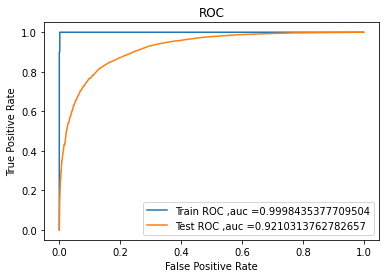

In [34]:
# plotting ROC curve for train & test data

false_positive_rate1 ,true_positive_rate1 ,threshold1 = roc_curve(y_train ,y_pred_rf_bow)
false_positive_rate2 ,true_positive_rate2 ,threshold2 = roc_curve(y_test ,y_pred_rf_bow_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1 ,true_positive_rate1 ,label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train ,y_pred_rf_bow))))

# test ROC
ax.plot(false_positive_rate2 ,true_positive_rate2 ,label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test ,y_pred_rf_bow_test))))

plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

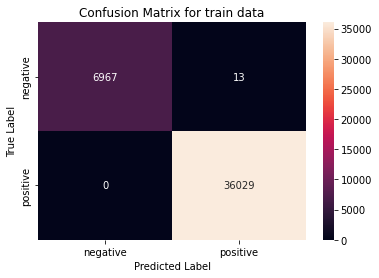

In [35]:
# confusion Matrix for train data
y_pred_rf_bow = rf_model_bow_gs.predict(X_train_bow)

confusion = confusion_matrix(y_train, y_pred_rf_bow)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

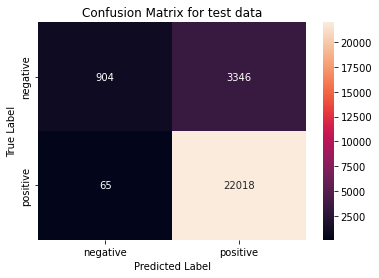

In [36]:
# confusion Matrix for test data
y_pred_rf_bow_test = rf_model_bow_gs.predict(X_test_bow)

confusion = confusion_matrix(y_test, y_pred_rf_bow_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 2. TFIDF - Random Forest

In [37]:
tfidf = TfidfVectorizer(ngram_range=(1,2) ,min_df=10)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_val_tfidf = tfidf.transform(X_val)

scaler = StandardScaler(with_mean=False) 

X_train_tfidf = scaler.fit_transform(X_train_tfidf)
X_test_tfidf = scaler.transform(X_test_tfidf)
X_val_tfidf = scaler.transform(X_val_tfidf)

### 2.1 Hyperparameter Tuning (GridSearchCV)

In [38]:
base_learners = [20,40,60,80,100,120]
depths = [1,5,10,50,100,500,1000]

parameter_grid = {'n_estimators': base_learners ,'max_depth':depths}

In [39]:
rf_model = RandomForestClassifier(max_features='sqrt')
model = HalvingGridSearchCV(rf_model ,parameter_grid ,scoring='roc_auc' ,cv=2 ,verbose=3)

model.fit(X_train_tfidf ,y_train) 
print('Optimal number of estimators --> ', model.best_estimator_.n_estimators)
print('Optimal max_depth --> ',model.best_estimator_.max_depth)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1592
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 42
n_resources: 1592
Fitting 2 folds for each of 42 candidates, totalling 84 fits
[CV 1/2] END max_depth=1, n_estimators=20;, score=(train=0.639, test=0.551) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=20;, score=(train=0.646, test=0.567) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=40;, score=(train=0.745, test=0.569) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=40;, score=(train=0.781, test=0.570) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=60;, score=(train=0.758, test=0.570) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=60;, score=(train=0.799, test=0.658) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=80;, score=(train=0.849, test=0.610) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=80;, score=(train=0.880, test=0.

In [40]:
X=[]
Y=[]
Z_train =[]
Z_cv =[]

for i in base_learners:
    for j in depths:
        classifier = RandomForestClassifier(max_features='sqrt',n_estimators=i,max_depth=j)
        classifier.fit(X_train_tfidf, y_train)
        
        # predicted values for train & validation data
        y_pred_rf_tfidf = classifier.predict_proba(X_train_tfidf)[:,1]
        y_pred_rf_tfidf_cv = classifier.predict_proba(X_val_tfidf)[:,1]
        
        # appending values to resp. lists 
        X.append(i)
        Y.append(j)
        Z_train.append(roc_auc_score(y_train, y_pred_rf_tfidf))
        Z_cv.append(roc_auc_score(y_val, y_pred_rf_tfidf_cv))
        
traindata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_train})
cvdata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_cv})


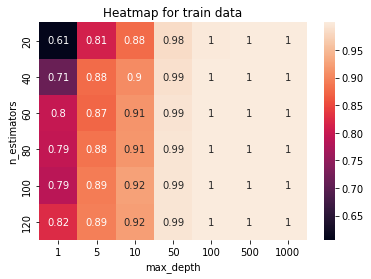

In [51]:
# Heatmap for train data
traindata_pivoted = traindata.pivot('n_estimators', 'max_depth', 'AUC')

sns.heatmap(traindata_pivoted, annot=True)
plt.title('Heatmap for train data')
plt.show()

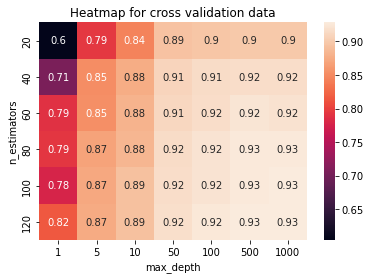

In [52]:
# Heatmap for cross validation data
cvdata_pivoted = cvdata.pivot('n_estimators', 'max_depth', 'AUC')

sns.heatmap(cvdata_pivoted, annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

### 2.2 Model Building (RF - TFIDF - GridSearchCV)

In [43]:
rf_model_tfidf_gs = RandomForestClassifier(max_features='sqrt',n_estimators=model.best_estimator_.n_estimators,max_depth=model.best_estimator_.max_depth)

rf_model_tfidf_gs.fit(X_train_tfidf ,y_train)

# predicted values for train & test data
y_pred_rf_tfidf = rf_model_tfidf_gs.predict_proba(X_train_tfidf)[:,1] = classifier.predict_proba(X_train_tfidf)[:,1]
y_pred_rf_tfidf_test = rf_model_tfidf_gs.predict_proba(X_test_tfidf)[:,1]


### 2.3 Model Evaluation (RF - TFIDF- GridSearchCV)

In [44]:
print('Accuracy of RF-TFIDF-GridSearchCV model : ',rf_model_tfidf_gs.score(X_test_tfidf ,y_test))

Accuracy of RF-TFIDF-GridSearchCV model :  0.8848972771807238


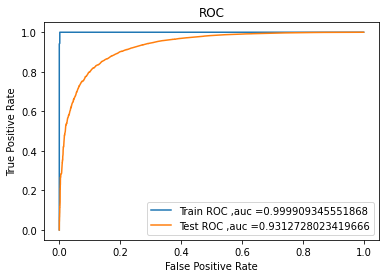

In [45]:
# plotting ROC curve for train & test data

false_positive_rate1 ,true_positive_rate1 ,threshold1 = roc_curve(y_train ,y_pred_rf_tfidf)
false_positive_rate2 ,true_positive_rate2 ,threshold2 = roc_curve(y_test ,y_pred_rf_tfidf_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1 ,true_positive_rate1 ,label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train ,y_pred_rf_tfidf))))

# test ROC
ax.plot(false_positive_rate2 ,true_positive_rate2 ,label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test ,y_pred_rf_tfidf_test))))

plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

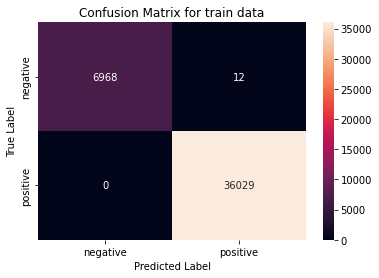

In [46]:
# confusion Matrix for train data
y_pred_rf_tfidf = rf_model_tfidf_gs.predict(X_train_tfidf)

confusion = confusion_matrix(y_train, y_pred_rf_tfidf)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

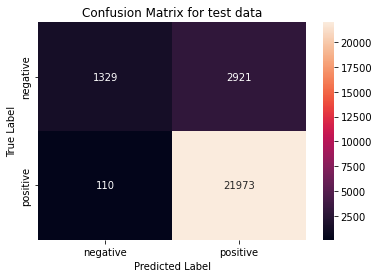

In [47]:
# confusion Matrix for test data
y_pred_rf_tfidf_test = rf_model_tfidf_gs.predict(X_test_tfidf)

confusion = confusion_matrix(y_test, y_pred_rf_tfidf_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 3. AVG W2V - Random Forest

In [54]:
#word2vec for train data

sent_list_train = []
sent_vectors_train = []

for sentence in X_train:
    sent_list_train.append(sentence.split())
    
w2v_model = Word2Vec(sent_list_train ,min_count=5 ,vector_size=50 ,workers=4)
w2v_words = list(w2v_model.wv.index_to_key)


for sent in tqdm(sent_list_train):
    sent_vectors = np.zeros(50)
    count_words = 0 
    
    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors 
            count_words += 1 
            
    if count_words != 0:
        sent_vectors /= count_words 
        
    sent_vectors_train.append(sent_vectors)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 43009/43009 [00:33<00:00, 1270.48it/s]

43009
50


In [68]:
#word2vec for validation data (using same w2v model and words)

sent_list_val = []
sent_vectors_val = []

for sentence in X_val:
    sent_list_val.append(sentence.split())

for sent in tqdm(sent_list_val):
    sent_vectors = np.zeros(50)
    count_words = 0 
    
    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors 
            count_words += 1 
            
    if count_words != 0:
        sent_vectors /= count_words 
        
    sent_vectors_val.append(sent_vectors)

print(len(sent_vectors_val))
print(len(sent_vectors_val[0]))

100%|██████████| 18433/18433 [00:14<00:00, 1308.49it/s]

18433
50


In [69]:
#word2vec for test data

sent_list_test = []
sent_vectors_test = []

for sentence in X_test:
    sent_list_test.append(sentence.split())

for sent in tqdm(sent_list_test):
    sent_vectors = np.zeros(50)
    count_words = 0 
    
    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors 
            count_words += 1 
            
    if count_words != 0:
        sent_vectors /= count_words 
        
    sent_vectors_test.append(sent_vectors)

print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 26333/26333 [00:19<00:00, 1317.34it/s]

26333
50


In [70]:
X_train_avg_w2v = sent_vectors_train
X_val_avg_w2v = sent_vectors_val
X_test_avg_w2v = sent_vectors_test

### 3.1 Hyperparameter Tuning (GridSearchCV)

In [71]:
base_learners = [20,40,60,80,100,120]
depths=[1,5,10,50,100,500,1000]
param_grid={'n_estimators': base_learners, 'max_depth':depths}

In [72]:
rf_model = RandomForestClassifier(max_features='sqrt')
model = HalvingGridSearchCV(rf_model ,param_grid ,scoring='roc_auc' ,cv=2 ,verbose=3)

model.fit(X_train_avg_w2v ,y_train) 
print('Optimal number of estimators --> ', model.best_estimator_.n_estimators)
print('Optimal max_depth --> ',model.best_estimator_.max_depth)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1592
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 42
n_resources: 1592
Fitting 2 folds for each of 42 candidates, totalling 84 fits
[CV 1/2] END max_depth=1, n_estimators=20;, score=(train=0.804, test=0.761) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=20;, score=(train=0.851, test=0.802) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=40;, score=(train=0.843, test=0.777) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=40;, score=(train=0.873, test=0.811) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=60;, score=(train=0.867, test=0.832) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=60;, score=(train=0.872, test=0.818) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=80;, score=(train=0.872, test=0.840) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=80;, score=(train=0.848, test=0.

In [73]:
X=[]
Y=[]
Z_train =[]
Z_cv =[]

for i in base_learners:
    for j in depths:
        classifier = RandomForestClassifier(max_features='sqrt',n_estimators=i,max_depth=j)
        classifier.fit(X_train_avg_w2v, y_train)
        
        # predicted values for train & validation data
        y_pred_rf_avg_w2v = classifier.predict_proba(X_train_avg_w2v)[:,1]
        y_pred_rf_avg_w2v_cv = classifier.predict_proba(X_val_avg_w2v)[:,1]
        
        # appending values to resp. lists 
        X.append(i)
        Y.append(j)
        Z_train.append(roc_auc_score(y_train, y_pred_rf_avg_w2v))
        Z_cv.append(roc_auc_score(y_val, y_pred_rf_avg_w2v_cv))
        
traindata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_train})
cvdata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_cv})


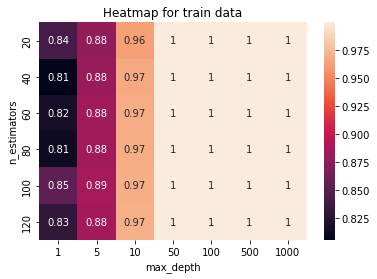

In [74]:
# Heatmap for train data
traindata_pivoted = traindata.pivot('n_estimators', 'max_depth', 'AUC')

sns.heatmap(traindata_pivoted, annot=True)
plt.title('Heatmap for train data')
plt.show()


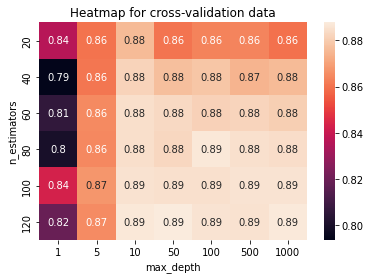

In [75]:
# Heatmap for cv data
cvdata_pivoted = cvdata.pivot('n_estimators', 'max_depth', 'AUC')

sns.heatmap(cvdata_pivoted, annot=True)
plt.title('Heatmap for cross-validation data')
plt.show()


### 3.2 Model Building (RF - AVG W2V - GridSearchCV)

In [76]:
rf_model_avg_w2v_gs = RandomForestClassifier(max_features='sqrt',n_estimators=model.best_estimator_.n_estimators,max_depth=model.best_estimator_.max_depth)

rf_model_avg_w2v_gs.fit(X_train_avg_w2v ,y_train)

# predicted values for train & test data
y_pred_rf_avg_w2v = rf_model_avg_w2v_gs.predict_proba(X_train_avg_w2v)[:,1] = classifier.predict_proba(X_train_avg_w2v)[:,1]
y_pred_rf_avg_w2v_test = rf_model_avg_w2v_gs.predict_proba(X_test_avg_w2v)[:,1]

### 3.3 Model Evaluation (RF - AVG W2V- GridSearchCV)

In [77]:
print('Accuracy of RF-AVG W2V-GridSearchCV model : ',rf_model_avg_w2v_gs.score(X_test_avg_w2v ,y_test))

Accuracy of RF-AVG W2V-GridSearchCV model :  0.8767705920328105


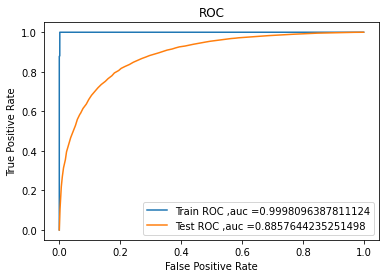

In [78]:
# plotting ROC curve for train & test data

false_positive_rate1 ,true_positive_rate1 ,threshold1 = roc_curve(y_train ,y_pred_rf_avg_w2v)
false_positive_rate2 ,true_positive_rate2 ,threshold2 = roc_curve(y_test ,y_pred_rf_avg_w2v_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1 ,true_positive_rate1 ,label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train ,y_pred_rf_avg_w2v))))

# test ROC
ax.plot(false_positive_rate2 ,true_positive_rate2 ,label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test ,y_pred_rf_avg_w2v_test))))

plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()


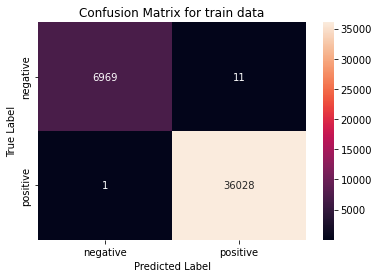

In [79]:
# confusion Matrix for train data
y_pred_rf_avg_w2v = rf_model_avg_w2v_gs.predict(X_train_avg_w2v)

confusion = confusion_matrix(y_train, y_pred_rf_avg_w2v)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

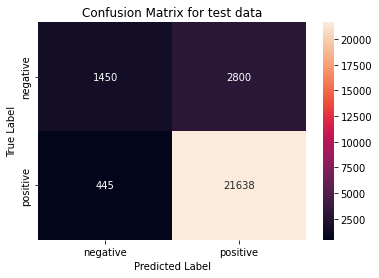

In [80]:
# confusion Matrix for test data
y_pred_rf_avg_w2v_test = rf_model_avg_w2v_gs.predict(X_test_avg_w2v)

confusion = confusion_matrix(y_test, y_pred_rf_avg_w2v_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## 4. TFIDF W2V - Random Forest

In [81]:
sent_list_train = []

for sentence in X_train:
    sent_list_train.append(sentence.split())
    
w2v_model = Word2Vec(sent_list_train ,min_count=5 ,vector_size=50 ,workers=4)
w2v_words = list(w2v_model.wv.index_to_key)


tfidf_vectors = TfidfVectorizer(ngram_range=(1,2) ,min_df=10 ,max_features=500)
tfidf_matrix = tfidf_vectors.fit_transform(X_train)

tfidf_features = tfidf_vectors.get_feature_names()
tfidf_dictionary = dict(zip(tfidf_vectors.get_feature_names() ,list(tfidf_vectors.idf_)))


#word2vec for train data

tfidf_sent_vectors_train = []
row = 0

for sent in tqdm(sent_list_train):
    sent_vectors = np.zeros(50)
    weight_sum = 0 
    
    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf) 
            weight_sum += tfidf
            
    if weight_sum != 0:
        sent_vectors /= weight_sum 
        
    tfidf_sent_vectors_train.append(sent_vectors)
    row +=1

100%|██████████| 43009/43009 [00:39<00:00, 1091.82it/s]


In [82]:
#word2vec for validation data (using same w2v model and words)

sent_list_val = []

for sentence in X_val:
    sent_list_val.append(sentence.split())

tfidf_sent_vectors_val = []
row = 0

for sent in tqdm(sent_list_val):
    sent_vectors = np.zeros(50)
    weight_sum = 0 
    
    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf) 
            weight_sum += tfidf
            
    if weight_sum != 0:
        sent_vectors /= weight_sum 
        
    tfidf_sent_vectors_val.append(sent_vectors)
    row +=1

100%|██████████| 18433/18433 [00:17<00:00, 1078.49it/s]


In [83]:
#word2vec for test data

sent_list_test = []

for sentence in X_test:
    sent_list_test.append(sentence.split())

tfidf_sent_vectors_test = []
row=0
    
for sent in tqdm(sent_list_val):
    sent_vectors = np.zeros(50)
    weight_sum = 0 
    
    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf) 
            weight_sum += tfidf
            
    if weight_sum != 0:
        sent_vectors /= weight_sum 
        
    tfidf_sent_vectors_val.append(sent_vectors)
    row +=1

100%|██████████| 18433/18433 [00:17<00:00, 1071.07it/s]


In [84]:
X_train_tfidf_w2v = sent_vectors_train
X_val_tfidf_w2v = sent_vectors_val
X_test_tfidf_w2v = sent_vectors_test

### 4.1 Hyperparameter Tuning (GridSearchCV)

In [85]:
base_learners = [20,40,60,80,100,120]
depths=[1,5,10,50,100,500,1000]

param_grid={'n_estimators': base_learners, 'max_depth':depths}

In [86]:
rf_model = RandomForestClassifier(max_features='sqrt')
model = HalvingGridSearchCV(rf_model ,param_grid ,scoring='roc_auc',cv=2 ,verbose=3)

model.fit(X_train_tfidf_w2v ,y_train) 
print('Optimal number of estimators --> ', model.best_estimator_.n_estimators)
print('Optimal max_depth --> ',model.best_estimator_.max_depth)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1592
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 42
n_resources: 1592
Fitting 2 folds for each of 42 candidates, totalling 84 fits
[CV 1/2] END max_depth=1, n_estimators=20;, score=(train=0.844, test=0.778) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=20;, score=(train=0.845, test=0.773) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=40;, score=(train=0.858, test=0.809) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=40;, score=(train=0.857, test=0.811) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=60;, score=(train=0.887, test=0.835) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=60;, score=(train=0.864, test=0.806) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=80;, score=(train=0.863, test=0.825) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=80;, score=(train=0.850, test=0.

In [87]:
X=[]
Y=[]
Z_train =[]
Z_cv =[]

for i in base_learners:
    for j in depths:
        classifier = RandomForestClassifier(max_features='sqrt',n_estimators=i,max_depth=j)
        classifier.fit(X_train_tfidf_w2v, y_train)
        
        # predicted values for train & validation data
        y_pred_rf_tfidf_w2v = classifier.predict_proba(X_train_tfidf_w2v)[:,1]
        y_pred_rf_tfidf_w2v_cv = classifier.predict_proba(X_val_tfidf_w2v)[:,1]
        
        # appending values to resp. lists 
        X.append(i)
        Y.append(j)
        Z_train.append(roc_auc_score(y_train, y_pred_rf_tfidf_w2v))
        Z_cv.append(roc_auc_score(y_val, y_pred_rf_tfidf_w2v_cv))
        
traindata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_train})
cvdata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_cv})


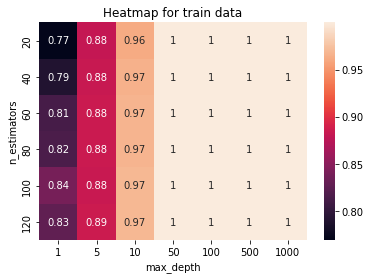

In [88]:
# Heatmap for train data
traindata_pivoted = traindata.pivot('n_estimators', 'max_depth', 'AUC')

sns.heatmap(traindata_pivoted, annot=True)
plt.title('Heatmap for train data')
plt.show()


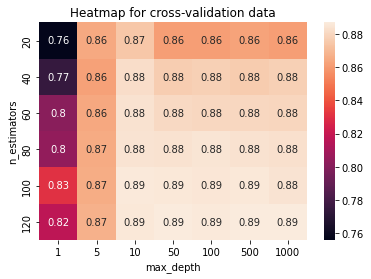

In [89]:
# Heatmap for cross-validation data
cvdata_pivoted = cvdata.pivot('n_estimators', 'max_depth', 'AUC')

sns.heatmap(cvdata_pivoted, annot=True)
plt.title('Heatmap for cross-validation data')
plt.show()


### 4.2 Model Building (RF - TFIDF W2V - GridSearchCV)

In [90]:
rf_model_tfidf_w2v_gs = RandomForestClassifier(max_features='sqrt',n_estimators=model.best_estimator_.n_estimators,max_depth=model.best_estimator_.max_depth)

rf_model_tfidf_w2v_gs.fit(X_train_tfidf_w2v ,y_train)

# predicted values for train & test data
y_pred_rf_tfidf_w2v = rf_model_tfidf_w2v_gs.predict_proba(X_train_tfidf_w2v)[:,1] = classifier.predict_proba(X_train_tfidf_w2v)[:,1]
y_pred_rf_tfidf_w2v_test = rf_model_tfidf_w2v_gs.predict_proba(X_test_tfidf_w2v)[:,1]

### 4.3 Model Evaluation (RF - TFIDF W2V - GridSearchCV)

In [91]:
print('Accuracy of RF-TFIDF W2V-GridSearchCV model : ',rf_model_tfidf_w2v_gs.score(X_test_tfidf_w2v ,y_test))

Accuracy of RF-TFIDF W2V-GridSearchCV model :  0.868302130406714


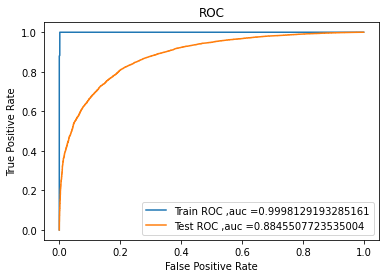

In [92]:
# plotting ROC curve for train & test data

false_positive_rate1 ,true_positive_rate1 ,threshold1 = roc_curve(y_train ,y_pred_rf_tfidf_w2v)
false_positive_rate2 ,true_positive_rate2 ,threshold2 = roc_curve(y_test ,y_pred_rf_tfidf_w2v_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1 ,true_positive_rate1 ,label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train ,y_pred_rf_tfidf_w2v))))

# test ROC
ax.plot(false_positive_rate2 ,true_positive_rate2 ,label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test ,y_pred_rf_tfidf_w2v_test))))

plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()


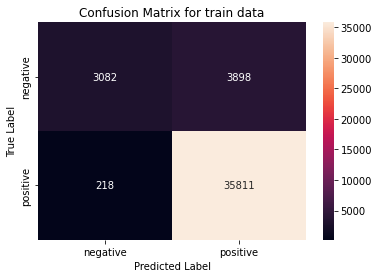

In [93]:
# confusion Matrix for train data
y_pred_rf_tfidf_w2v = rf_model_tfidf_w2v_gs.predict(X_train_tfidf_w2v)

confusion = confusion_matrix(y_train, y_pred_rf_tfidf_w2v)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


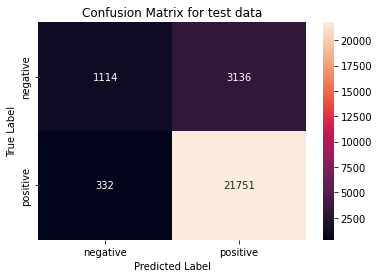

In [94]:
# confusion Matrix for test data
y_pred_rf_tfidf_w2v_test = rf_model_tfidf_w2v_gs.predict(X_test_tfidf_w2v)

confusion = confusion_matrix(y_test, y_pred_rf_tfidf_w2v_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 5. Bag of Words (BoW) - GBDT

In [95]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)
X_val_bow = vectorizer.transform(X_val)

scaler = StandardScaler(with_mean=False) 
X_train_bow = scaler.fit_transform(X_train_bow)
X_test_bow = scaler.transform(X_test_bow)
X_val_bow = scaler.transform(X_val_bow)

### 5.1 Hyperparameter Tuning (GridSearchCV)

In [96]:
base_learners = [20,40,60,80,100,120]
depths = [1,5,10,50,100,500,1000]

parameter_grid = {'n_estimators': base_learners ,'max_depth':depths}

In [101]:
from xgboost import XGBClassifier

# gbdt_model = XGBClassifier(booster='gbtree',tree_method='gpu_hist' ,predictor='gpu_predictor',use_label_encoder =False,eval_metric='logloss')

gbdt_model = XGBClassifier(booster='gbtree', eval_metric='logloss')
model = HalvingGridSearchCV(gbdt_model ,parameter_grid ,scoring='roc_auc' ,cv=2 ,verbose=3)

model.fit(X_train_bow ,y_train) 
print('Optimal number of estimators --> ', model.best_estimator_.n_estimators)
print('Optimal max_depth --> ',model.best_estimator_.max_depth)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1592
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 42
n_resources: 1592
Fitting 2 folds for each of 42 candidates, totalling 84 fits
[CV 1/2] END max_depth=1, n_estimators=20;, score=(train=0.823, test=0.774) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=20;, score=(train=0.828, test=0.741) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=40;, score=(train=0.874, test=0.811) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=40;, score=(train=0.860, test=0.762) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=60;, score=(train=0.902, test=0.816) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=60;, score=(train=0.894, test=0.786) total time=   0.1s
[CV 1/2] END max_depth=1, n_estimators=80;, score=(train=0.926, test=0.834) total time=   0.1s
[CV 2/2] END max_depth=1, n_estimators=80;, score=(train=0.916, test=0.

In [103]:
X=[]
Y=[]
Z_train =[]
Z_cv =[]
for i in base_learners:
    for j in depths:
        classifier = XGBClassifier(booster='gbtree', n_estimators=i,
                                   max_depth=j,eval_metric='logloss')
        classifier.fit(X_train_bow, y_train)
        
        # predicted values for train & validation data
        y_pred_gbdt_bow = classifier.predict_proba(X_train_bow)[:,1]
        y_pred_gbdt_bow_cv = classifier.predict_proba(X_val_bow)[:,1]
        
        # appending values to resp. lists 
        X.append(i)
        Y.append(j)
        Z_train.append(roc_auc_score(y_train, y_pred_gbdt_bow))
        Z_cv.append(roc_auc_score(y_val, y_pred_gbdt_bow_cv))
        
traindata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_train})
cvdata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_cv})


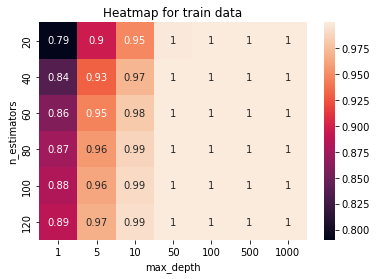

In [104]:
# Heatmap for train data
traindata_pivoted = traindata.pivot('n_estimators' ,'max_depth' ,'AUC')

sns.heatmap(traindata_pivoted,annot=True)
plt.title('Heatmap for train data')
plt.show()

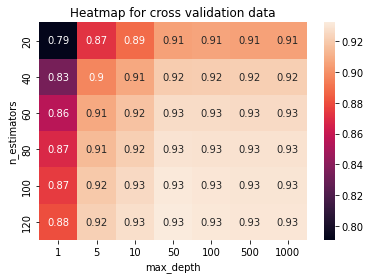

In [105]:
# Heatmap for cross validation data
cvdata_pivoted = cvdata.pivot('n_estimators' ,'max_depth' ,'AUC')

sns.heatmap(cvdata_pivoted,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

### 5.2 Model Building (GBDT - BoW - GridSearchCV)

In [106]:
gbdt_model_bow_gs = XGBClassifier(booster='gbtree', n_estimators=model.best_estimator_.n_estimators,max_depth=model.best_estimator_.max_depth, eval_metric='logloss')

gbdt_model_bow_gs.fit(X_train_bow ,y_train)

# predicted values for train & test data
y_pred_gbdt_bow = gbdt_model_bow_gs.predict_proba(X_train_bow)[:,1] 
y_pred_gbdt_bow_test = gbdt_model_bow_gs.predict_proba(X_test_bow)[:,1]


### 5.3 Model Evaluation (GBDT - BoW - GridSearchCV)


In [107]:
print('Accuracy of GBDT-BoW-GridSearchCV model : ',gbdt_model_bow_gs.score(X_test_bow ,y_test))

Accuracy of GBDT-BoW-GridSearchCV model :  0.9008468461626097


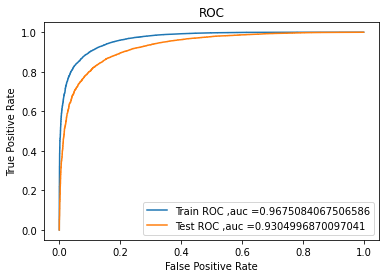

In [108]:
# plotting ROC curve for train & test data

false_positive_rate1 ,true_positive_rate1 ,threshold1 = roc_curve(y_train ,y_pred_gbdt_bow)
false_positive_rate2 ,true_positive_rate2 ,threshold2 = roc_curve(y_test ,y_pred_gbdt_bow_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1 ,true_positive_rate1 ,label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train ,y_pred_gbdt_bow))))

# test ROC
ax.plot(false_positive_rate2 ,true_positive_rate2 ,label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test ,y_pred_gbdt_bow_test))))

plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

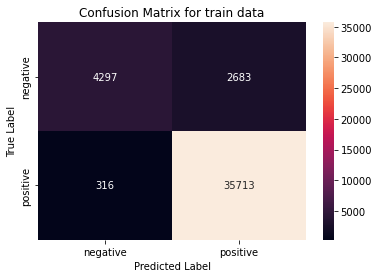

In [109]:
# confusion Matrix for train data
y_pred_gbdt_bow = gbdt_model_bow_gs.predict(X_train_bow)

confusion = confusion_matrix(y_train, y_pred_gbdt_bow)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


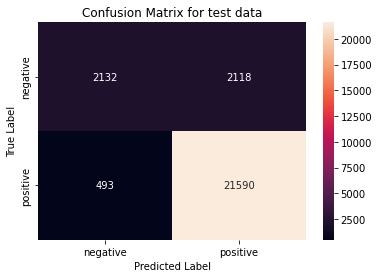

In [110]:
# confusion Matrix for test data
y_pred_gbdt_bow_test = gbdt_model_bow_gs.predict(X_test_bow)

confusion = confusion_matrix(y_test, y_pred_gbdt_bow_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 6. TFIDF - GBDT

In [111]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=10)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_val_tfidf = tfidf.transform(X_val)

scaler = StandardScaler(with_mean=False)

X_train_tfidf = scaler.fit_transform(X_train_tfidf)
X_test_tfidf = scaler.transform(X_test_tfidf)
X_val_tfidf = scaler.transform(X_val_tfidf)


### 6.1 Hyperparameter Tuning (GridSearchCV)

In [112]:
base_learners = [20,40,60,80,100,120]
depths = [1,5,10,50,100,500,1000]

parameter_grid = {'n_estimators': base_learners ,'max_depth':depths}

In [113]:
# gbdt_model = XGBClassifier(
#     booster='gbtree', tree_method='gpu_hist', predictor='gpu_predictor',use_label_encoder =False,eval_metric='logloss')

gbdt_model = XGBClassifier(booster='gbtree', eval_metric='logloss')
    
model = HalvingGridSearchCV(gbdt_model ,parameter_grid ,scoring='roc_auc',cv=2 ,verbose=3)

model.fit(X_train_tfidf ,y_train) 
print('Optimal number of estimators --> ', model.best_estimator_.n_estimators)
print('Optimal max_depth --> ',model.best_estimator_.max_depth)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1592
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 42
n_resources: 1592
Fitting 2 folds for each of 42 candidates, totalling 84 fits
[CV 1/2] END max_depth=1, n_estimators=20;, score=(train=0.883, test=0.733) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=20;, score=(train=0.836, test=0.752) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=40;, score=(train=0.927, test=0.766) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=40;, score=(train=0.907, test=0.774) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=60;, score=(train=0.949, test=0.775) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=60;, score=(train=0.934, test=0.788) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=80;, score=(train=0.963, test=0.783) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=80;, score=(train=0.955, test=0.

In [114]:
X=[]
Y=[]
Z_train =[]
Z_cv =[]
for i in base_learners:
    for j in depths:
        classifier = XGBClassifier(booster='gbtree', n_estimators=i,
                                   max_depth=j,eval_metric='logloss')
        classifier.fit(X_train_tfidf, y_train)
        
        # predicted values for train & validation data
        y_pred_gbdt_tfidf = classifier.predict_proba(X_train_tfidf)[:,1]
        y_pred_gbdt_tfidf_cv = classifier.predict_proba(X_val_tfidf)[:,1]
        
        # appending values to resp. lists 
        X.append(i)
        Y.append(j)
        Z_train.append(roc_auc_score(y_train, y_pred_gbdt_tfidf))
        Z_cv.append(roc_auc_score(y_val, y_pred_gbdt_tfidf_cv))
        
traindata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_train})
cvdata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_cv})


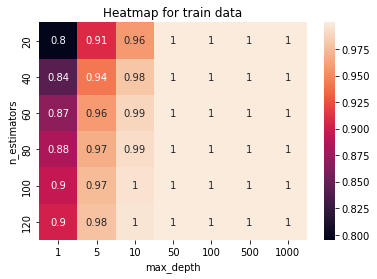

In [115]:
# Heatmap for train data
traindata_pivoted = traindata.pivot('n_estimators' ,'max_depth' ,'AUC')

sns.heatmap(traindata_pivoted,annot=True)
plt.title('Heatmap for train data')
plt.show()

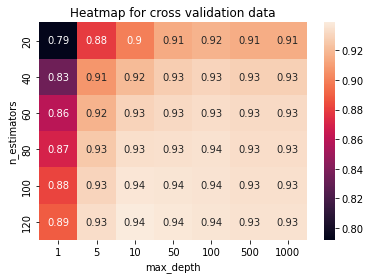

In [122]:
# Heatmap for cross validation data
cvdata_pivoted = cvdata.pivot('n_estimators' ,'max_depth' ,'AUC')

sns.heatmap(cvdata_pivoted,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

### 6.2 Model Building (GBDT - TFIDF - GridSearchCV)

In [117]:
gbdt_model_tfidf_gs = XGBClassifier(booster='gbtree', n_estimators=model.best_estimator_.n_estimators,max_depth=model.best_estimator_.max_depth, eval_metric='logloss')

gbdt_model_tfidf_gs.fit(X_train_tfidf ,y_train)

# predicted values for train & test data
y_pred_gbdt_tfidf = gbdt_model_tfidf_gs.predict_proba(X_train_tfidf)[:,1] 
y_pred_gbdt_tfidf_test = gbdt_model_tfidf_gs.predict_proba(X_test_tfidf)[:,1]


### 6.3 Model Evaluation (GBDT - TFIDF - GridSearchCV)

In [118]:
print('Accuracy of GBDT-TFIDF-GridSearchCV model : ',gbdt_model_tfidf_gs.score(X_test_tfidf ,y_test))

Accuracy of GBDT-TFIDF-GridSearchCV model :  0.9070747730983937


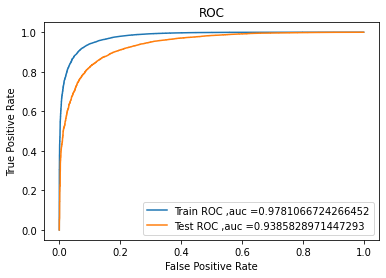

In [119]:
# plotting ROC curve for train & test data

false_positive_rate1 ,true_positive_rate1 ,threshold1 = roc_curve(y_train ,y_pred_gbdt_tfidf)
false_positive_rate2 ,true_positive_rate2 ,threshold2 = roc_curve(y_test ,y_pred_gbdt_tfidf_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1 ,true_positive_rate1 ,label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train ,y_pred_gbdt_tfidf))))

# test ROC
ax.plot(false_positive_rate2 ,true_positive_rate2 ,label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test ,y_pred_gbdt_tfidf_test))))

plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

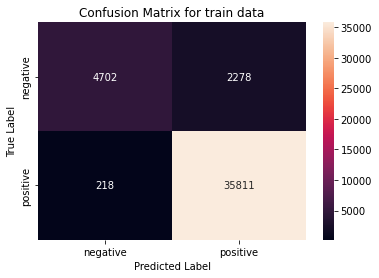

In [120]:
# confusion Matrix for train data
y_pred_gbdt_tfidf = gbdt_model_tfidf_gs.predict(X_train_tfidf)

confusion = confusion_matrix(y_train, y_pred_gbdt_tfidf)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

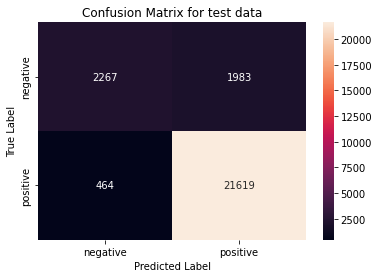

In [121]:
# confusion Matrix for test data
y_pred_gbdt_tfidf_test = gbdt_model_tfidf_gs.predict(X_test_tfidf)

confusion = confusion_matrix(y_test, y_pred_gbdt_tfidf_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 7. AVG W2V - GBDT

In [123]:
#word2vec for train data

sent_list_train = []
sent_vectors_train = []

for sentence in X_train:
    sent_list_train.append(sentence.split())
    
w2v_model = Word2Vec(sent_list_train ,min_count=5 ,vector_size=50 ,workers=4)
w2v_words = list(w2v_model.wv.index_to_key)


for sent in tqdm(sent_list_train):
    sent_vectors = np.zeros(50)
    count_words = 0 
    
    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors 
            count_words += 1 
            
    if count_words != 0:
        sent_vectors /= count_words 
        
    sent_vectors_train.append(sent_vectors)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 43009/43009 [00:41<00:00, 1037.19it/s]

43009
50


In [124]:
#word2vec for validation data (using same w2v model and words)

sent_list_val = []
sent_vectors_val = []

for sentence in X_val:
    sent_list_val.append(sentence.split())

for sent in tqdm(sent_list_val):
    sent_vectors = np.zeros(50)
    count_words = 0 
    
    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors 
            count_words += 1 
            
    if count_words != 0:
        sent_vectors /= count_words 
        
    sent_vectors_val.append(sent_vectors)

print(len(sent_vectors_val))
print(len(sent_vectors_val[0]))

100%|██████████| 18433/18433 [00:18<00:00, 997.30it/s] 

18433
50


In [125]:
#word2vec for test data

sent_list_test = []
sent_vectors_test = []

for sentence in X_test:
    sent_list_test.append(sentence.split())

for sent in tqdm(sent_list_test):
    sent_vectors = np.zeros(50)
    count_words = 0 
    
    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors 
            count_words += 1 
            
    if count_words != 0:
        sent_vectors /= count_words 
        
    sent_vectors_test.append(sent_vectors)

print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|██████████| 26333/26333 [00:26<00:00, 990.28it/s]

26333
50


In [126]:
X_train_avg_w2v = sent_vectors_train
X_val_avg_w2v = sent_vectors_val
X_test_avg_w2v = sent_vectors_test

### 7.1 Hyperparameter Tuning (GridSearchCV)

In [127]:
base_learners = [20,40,60,80,100,120]
depths=[1,5,10,50,100,500,1000]
param_grid={'n_estimators': base_learners, 'max_depth':depths}

In [128]:
# gbdt_model = XGBClassifier(
#     booster='gbtree', tree_method='gpu_hist', predictor='gpu_predictor',use_label_encoder =False,eval_metric='logloss')

gbdt_model = XGBClassifier(booster='gbtree', eval_metric='logloss')

model = HalvingGridSearchCV(gbdt_model ,parameter_grid ,scoring='roc_auc' ,cv=2 ,verbose=3)

model.fit(X_train_avg_w2v ,y_train) 
print('Optimal number of estimators --> ', model.best_estimator_.n_estimators)
print('Optimal max_depth --> ',model.best_estimator_.max_depth)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1592
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 42
n_resources: 1592
Fitting 2 folds for each of 42 candidates, totalling 84 fits
[CV 1/2] END max_depth=1, n_estimators=20;, score=(train=0.911, test=0.821) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=20;, score=(train=0.894, test=0.827) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=40;, score=(train=0.939, test=0.838) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=40;, score=(train=0.933, test=0.857) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=60;, score=(train=0.955, test=0.844) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=60;, score=(train=0.949, test=0.855) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=80;, score=(train=0.965, test=0.849) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=80;, score=(train=0.963, test=0.

In [129]:
X=[]
Y=[]
Z_train =[]
Z_cv =[]

for i in base_learners:
    for j in depths:
        classifier = XGBClassifier(booster='gbtree', n_estimators=i,
                                   max_depth=j,eval_metric='logloss')
        classifier.fit(X_train_avg_w2v, y_train)
        
        # predicted values for train & validation data
        y_pred_gbdt_avg_w2v = classifier.predict_proba(X_train_avg_w2v)[:,1]
        y_pred_gbdt_avg_w2v_cv = classifier.predict_proba(X_val_avg_w2v)[:,1]
        
        # appending values to resp. lists 
        X.append(i)
        Y.append(j)
        Z_train.append(roc_auc_score(y_train, y_pred_gbdt_avg_w2v))
        Z_cv.append(roc_auc_score(y_val, y_pred_gbdt_avg_w2v_cv))
        
traindata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_train})
cvdata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_cv})


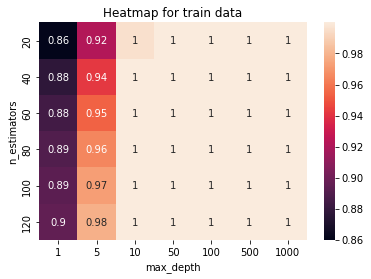

In [130]:
# Heatmap for train data
traindata_pivoted = traindata.pivot('n_estimators', 'max_depth', 'AUC')

sns.heatmap(traindata_pivoted, annot=True)
plt.title('Heatmap for train data')
plt.show()


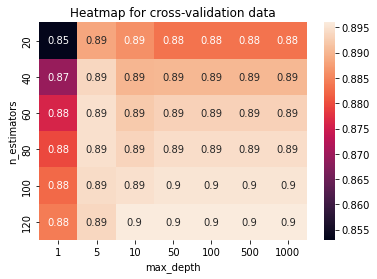

In [131]:
# Heatmap for cv data
cvdata_pivoted = cvdata.pivot('n_estimators', 'max_depth', 'AUC')

sns.heatmap(cvdata_pivoted, annot=True)
plt.title('Heatmap for cross-validation data')
plt.show()


### 7.2 Model Building (GBDT - AVG W2V - GridSearchCV)

In [132]:
gbdt_model_avg_w2v_gs = XGBClassifier(booster='gbtree', n_estimators=model.best_estimator_.n_estimators,max_depth=model.best_estimator_.max_depth, eval_metric='logloss')

gbdt_model_avg_w2v_gs.fit(X_train_avg_w2v ,y_train)

# predicted values for train & test data
y_pred_gbdt_avg_w2v = gbdt_model_avg_w2v_gs.predict_proba(X_train_avg_w2v)[:,1] = classifier.predict_proba(X_train_avg_w2v)[:,1]

y_pred_gbdt_avg_w2v_test = gbdt_model_avg_w2v_gs.predict_proba(X_test_avg_w2v)[:,1]


### 7.3 Model Evaluation (GBDT - AVG W2V- GridSearchCV)

In [133]:
print('Accuracy of GBDT-AVG W2V-GridSearchCV model : ',gbdt_model_avg_w2v_gs.score(X_test_avg_w2v ,y_test))

Accuracy of GBDT-AVG W2V-GridSearchCV model :  0.8833402954467778


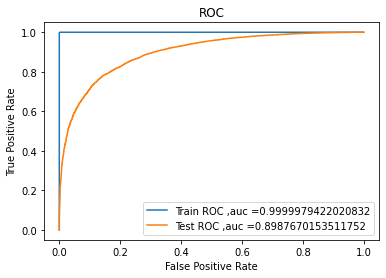

In [134]:
# plotting ROC curve for train & test data

false_positive_rate1 ,true_positive_rate1 ,threshold1 = roc_curve(y_train ,y_pred_gbdt_avg_w2v)
false_positive_rate2 ,true_positive_rate2 ,threshold2 = roc_curve(y_test ,y_pred_gbdt_avg_w2v_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1 ,true_positive_rate1 ,label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train ,y_pred_gbdt_avg_w2v))))

# test ROC
ax.plot(false_positive_rate2 ,true_positive_rate2 ,label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test ,y_pred_gbdt_avg_w2v_test))))

plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

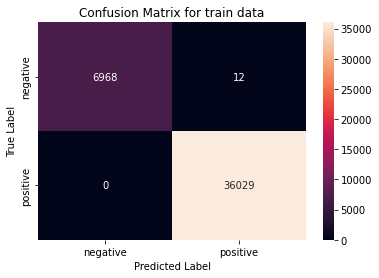

In [135]:
# confusion Matrix for train data
y_pred_gbdt_avg_w2v = gbdt_model_avg_w2v_gs.predict(X_train_avg_w2v)

confusion = confusion_matrix(y_train, y_pred_gbdt_avg_w2v)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

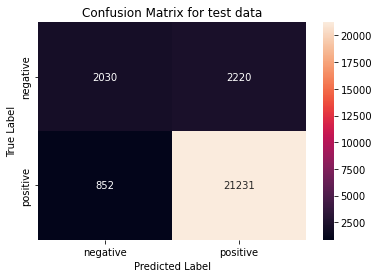

In [136]:
# confusion Matrix for test data
y_pred_gbdt_avg_w2v_test = gbdt_model_avg_w2v_gs.predict(X_test_avg_w2v)

confusion = confusion_matrix(y_test, y_pred_gbdt_avg_w2v_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 8. TFIDF W2V - GBDT

In [137]:
sent_list_train = []

for sentence in X_train:
    sent_list_train.append(sentence.split())
    
w2v_model = Word2Vec(sent_list_train ,min_count=5 ,vector_size=50 ,workers=4)
w2v_words = list(w2v_model.wv.index_to_key)


tfidf_vectors = TfidfVectorizer(ngram_range=(1,2) ,min_df=10 ,max_features=500)
tfidf_matrix = tfidf_vectors.fit_transform(X_train)

tfidf_features = tfidf_vectors.get_feature_names()
tfidf_dictionary = dict(zip(tfidf_vectors.get_feature_names() ,list(tfidf_vectors.idf_)))


#word2vec for train data

tfidf_sent_vectors_train = []
row = 0

for sent in tqdm(sent_list_train):
    sent_vectors = np.zeros(50)
    weight_sum = 0 
    
    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf) 
            weight_sum += tfidf
            
    if weight_sum != 0:
        sent_vectors /= weight_sum 
        
    tfidf_sent_vectors_train.append(sent_vectors)
    row +=1

100%|██████████| 43009/43009 [00:50<00:00, 848.35it/s]


In [138]:
#word2vec for validation data (using same w2v model and words)

sent_list_val = []

for sentence in X_val:
    sent_list_val.append(sentence.split())

tfidf_sent_vectors_val = []
row = 0

for sent in tqdm(sent_list_val):
    sent_vectors = np.zeros(50)
    weight_sum = 0 
    
    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf) 
            weight_sum += tfidf
            
    if weight_sum != 0:
        sent_vectors /= weight_sum 
        
    tfidf_sent_vectors_val.append(sent_vectors)
    row +=1

100%|██████████| 18433/18433 [00:22<00:00, 835.41it/s]


In [139]:
#word2vec for test data

sent_list_test = []

for sentence in X_test:
    sent_list_test.append(sentence.split())

tfidf_sent_vectors_test = []
row=0
    
for sent in tqdm(sent_list_val):
    sent_vectors = np.zeros(50)
    weight_sum = 0 
    
    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf) 
            weight_sum += tfidf
            
    if weight_sum != 0:
        sent_vectors /= weight_sum 
        
    tfidf_sent_vectors_val.append(sent_vectors)
    row +=1


100%|██████████| 18433/18433 [00:21<00:00, 840.23it/s]


In [140]:
X_train_tfidf_w2v = sent_vectors_train
X_val_tfidf_w2v = sent_vectors_val
X_test_tfidf_w2v = sent_vectors_test

### 8.1 Hyperparameter Tuning (GridSearchCV)

In [141]:
base_learners = [20,40,60,80,100,120]
depths=[1,5,10,50,100,500,1000]
param_grid={'n_estimators': base_learners, 'max_depth':depths}

In [142]:
# gbdt_model = XGBClassifier(booster='gbtree',tree_method='gpu_hist', predictor='gpu_predictor',use_label_encoder =False,eval_metric='logloss')

gbdt_model = XGBClassifier(booster='gbtree', eval_metric='logloss')

model = HalvingGridSearchCV(gbdt_model ,parameter_grid ,scoring='roc_auc' ,cv=2 ,verbose=3)

model.fit(X_train_tfidf_w2v ,y_train) 

print('Optimal number of estimators --> ', model.best_estimator_.n_estimators)
print('Optimal max_depth --> ',model.best_estimator_.max_depth)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1592
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 42
n_resources: 1592
Fitting 2 folds for each of 42 candidates, totalling 84 fits
[CV 1/2] END max_depth=1, n_estimators=20;, score=(train=0.901, test=0.856) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=20;, score=(train=0.889, test=0.840) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=40;, score=(train=0.922, test=0.872) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=40;, score=(train=0.920, test=0.856) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=60;, score=(train=0.940, test=0.880) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=60;, score=(train=0.940, test=0.857) total time=   0.0s
[CV 1/2] END max_depth=1, n_estimators=80;, score=(train=0.952, test=0.879) total time=   0.0s
[CV 2/2] END max_depth=1, n_estimators=80;, score=(train=0.953, test=0.

In [145]:
X=[]
Y=[]
Z_train =[]
Z_val =[]

for i in base_learners:
    for j in depths:
        classifier = XGBClassifier(booster='gbtree', n_estimators=i,
                                   max_depth=j,eval_metric='logloss')
        classifier.fit(X_train_tfidf_w2v, y_train)
        
        # predicted values for train & validation data
        y_pred_gbdt_tfidf_w2v = classifier.predict_proba(X_train_tfidf_w2v)[:,1]
        y_pred_gbdt_tfidf_w2v_cv = classifier.predict_proba(X_val_tfidf_w2v)[:,1]
        
        # appending values to resp. lists 
        X.append(i)
        Y.append(j)
        Z_train.append(roc_auc_score(y_train, y_pred_gbdt_tfidf_w2v))
        Z_val.append(roc_auc_score(y_val, y_pred_gbdt_tfidf_w2v_cv))
        
traindata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_train})
cvdata = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z_val})


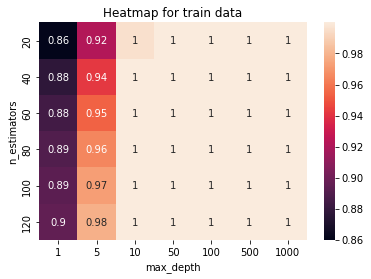

In [146]:
# Heatmap for train data
traindata_pivoted = traindata.pivot('n_estimators', 'max_depth', 'AUC')

sns.heatmap(traindata_pivoted, annot=True)
plt.title('Heatmap for train data')
plt.show()


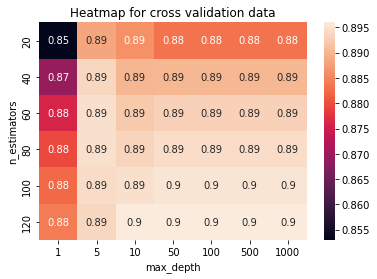

In [147]:
# Heatmap for cross validation data
cvdata_pivoted = cvdata.pivot('n_estimators', 'max_depth', 'AUC')

sns.heatmap(cvdata_pivoted, annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

### 8.2 Model Building (GBDT - TFIDF W2V - GridSearchCV)

In [148]:
gbdt_model_tfidf_w2v_gs = XGBClassifier(booster='gbtree', n_estimators=model.best_estimator_.n_estimators,max_depth=model.best_estimator_.max_depth, eval_metric='logloss')

gbdt_model_tfidf_w2v_gs.fit(X_train_tfidf_w2v ,y_train)

# predicted values for train & test data
y_pred_gbdt_tfidf_w2v = gbdt_model_tfidf_w2v_gs.predict_proba(X_train_tfidf_w2v)[:,1] = classifier.predict_proba(X_train_tfidf_w2v)[:,1]

y_pred_gbdt_tfidf_w2v_test = gbdt_model_tfidf_w2v_gs.predict_proba(X_test_tfidf_w2v)[:,1]


### 8.3 Model Evaluation (GBDT - TFIDF W2V- GridSearchCV)

In [149]:
print('Accuracy of GBDT-TFIDF W2V-GridSearchCV model : ',gbdt_model_tfidf_w2v_gs.score(X_test_tfidf_w2v ,y_test))

Accuracy of GBDT-TFIDF W2V-GridSearchCV model :  0.8831883947898075


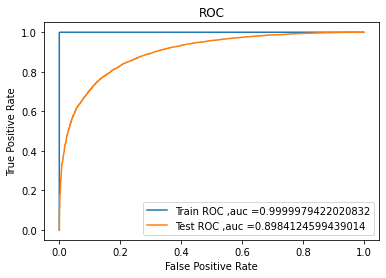

In [150]:
# plotting ROC curve for train & test data

false_positive_rate1 ,true_positive_rate1 ,threshold1 = roc_curve(y_train ,y_pred_gbdt_tfidf_w2v)
false_positive_rate2 ,true_positive_rate2 ,threshold2 = roc_curve(y_test ,y_pred_gbdt_tfidf_w2v_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1 ,true_positive_rate1 ,label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train ,y_pred_gbdt_tfidf_w2v))))

# test ROC
ax.plot(false_positive_rate2 ,true_positive_rate2 ,label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test ,y_pred_gbdt_tfidf_w2v_test))))

plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

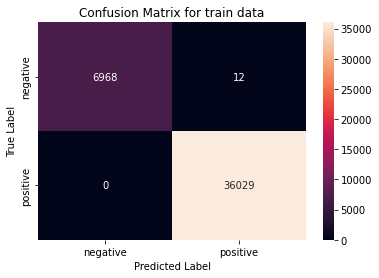

In [151]:
# confusion Matrix for train data
y_pred_gbdt_tfidf_w2v = gbdt_model_tfidf_w2v_gs.predict(X_train_tfidf_w2v)

confusion = confusion_matrix(y_train, y_pred_gbdt_tfidf_w2v)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

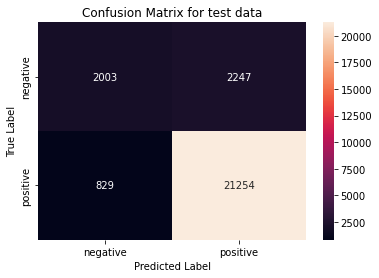

In [152]:
# confusion Matrix for test data
y_pred_gbdt_tfidf_w2v_test = gbdt_model_tfidf_w2v_gs.predict(X_test_tfidf_w2v)

confusion = confusion_matrix(y_test, y_pred_gbdt_tfidf_w2v_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
sns.heatmap(cf_data, annot = True,fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Model Comparision

### Creating a prettytable to see which model performed better

In [2]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ['Vectorizer','Model', 'n_estimators','max_depth', 'AUC']
x.add_row(['BOW','RF',120 ,500,0.92103])
x.add_row(['TFIDF','RF',100,500,0.93127])
x.add_row(['AVG-W2V','RF',120,100,0.88576])
x.add_row(['TFIDF-W2V','RF',120,10, 0.88455])
x.add_row(['BOW','GBDT',120,5, 0.93049])
x.add_row(['TFIDF','GBDT',120,5, 0.93858])
x.add_row(['AVG-W2V','GBDT',100,10, 0.89876])
x.add_row(['TFIDF-W2V','GBDT',80,500, 0.89841])

x.sortby = 'AUC'
x.reversesort = True
print(x)


+------------+-------+--------------+-----------+---------+
| Vectorizer | Model | n_estimators | max_depth |   AUC   |
+------------+-------+--------------+-----------+---------+
|   TFIDF    |  GBDT |     120      |     5     | 0.93858 |
|   TFIDF    |   RF  |     100      |    500    | 0.93127 |
|    BOW     |  GBDT |     120      |     5     | 0.93049 |
|    BOW     |   RF  |     120      |    500    | 0.92103 |
|  AVG-W2V   |  GBDT |     100      |     10    | 0.89876 |
| TFIDF-W2V  |  GBDT |      80      |    500    | 0.89841 |
|  AVG-W2V   |   RF  |     120      |    100    | 0.88576 |
| TFIDF-W2V  |   RF  |     120      |     10    | 0.88455 |
+------------+-------+--------------+-----------+---------+
